# 1. Data Acquisition and Initial Notebook Setup

Data was retrieved from NCBI's GEO database. This data was sourced from a GEO entry by TJ Schulz and M Leer (no associated publication) (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE247313). The dataset is described by the authors as a transcriptional data that can bne used to "analyze the cellular heterogeneity of mononucleated, non-myofiber cell populations and their transcriptional states in post-injury skeletal muscle". 

This notebook is concerned with the data analysis of young samples. 

In [3]:
#install and import the immediately necessary libraries
!pip install numpy
!pip install pandas
!pip install scanpy
!pip install matplotlib
!pip install seaborn

import scanpy as sc 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **'2. Loading/Reading Data' and 'Doublet Removal' steps can be skipped, as this requires training a model for doublet detection, which can be time consuming and requires considerable compute power. I have filtered the AnnData object and written it to a new file in the 'doublet_filtered' folder in the 'data' folder. Skip to "Read in doublet filtered data"**

---

# 2. Loading/Reading Data 

In [ ]:
#importing data for young, post-injury skeletal muscle samples, adjust for your directory
adata = sc.read_mtx('data/raw_data/GSE247313_RAW/GSM7887083_B3_matrix.mtx.gz').T #Read data matrix and make it transposable (.T) - this files holds the count matrix sourced from the young muscle sample
adata.var_names = pd.read_csv('data/raw_data/GSE247313_RAW/GSM7887083_B3_features.tsv', header = None)[0] #include gene names
adata.obs_names = pd.read_csv('data/raw_adata/GSE247313_RAW/GSM7887083_B3_barcodes.tsv.gz', header = None)[0] # include barcode/"cell" identifier

adata

# 3. Quality Control

I am looking to remove low quality reads from the dataset. I will be aiming to remove cells with low number of detected genes, low count depth, and high fraction of mitochondrial counts. Barcodes with these characteritics may indicate dead, non-viable cells (ex. cells with broken membranes), empty droplets or doublets.

I will be starting with doublet removal

### Doublet removal

In [ ]:
import scvi 

sc.pp.filter_genes(adata, min_cells = 10)
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

In [ ]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

In [ ]:
doub_df = solo.predict()
doub_df['prediction'] = solo.predict(soft = False)

#doub_df.index = doub_df.index.map(lambda x: x[:-2])

doub_df


In [ ]:
doub_df.groupby('prediction').count()

In [ ]:
doub_df['dif'] = doub_df.doublet - doub_df.singlet

sns.displot(doub_df[doub_df.prediction == 'doublet'], x = 'dif')

In [ ]:
doublets = doub_df[(doub_df.prediction == 'doublet') & (doub_df.dif > 1)]
doublets

In [ ]:
adata = sc.read_mtx('GSE247313_RAW/GSM7887083_B3_matrix.mtx.gz').T
adata.var_names = pd.read_csv('GSE247313_RAW/GSM7887083_B3_features.tsv', header = None)[0] #include gene names
adata.obs_names = pd.read_csv('GSE247313_RAW/GSM7887083_B3_barcodes.tsv.gz', header = None)[0] # include barcode/"cell" identifier

In [ ]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [ ]:
adata_filtered = adata[~adata.obs.doublet]

In [ ]:
adata_filtered

In [ ]:
adata_filtered.write('young_filtered_adata.h5ad') #writes a new file for doublet filtered data so we don't need to train the model on every run

---

## **Read in doublet filtered data**

You can skip to here to read in the doublet filtered AnnData object.

In [4]:
path = 'SCAMP_scRNAseq_Agolini_Iyer_Lab\data\doublet_filtered\young_filtered_adata.h5ad' #adjust to suit your respective directory
adata = sc.read_h5ad(path) 

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Continued Preprocessing

Eliminating low quality reads (ex non viable cells, empty droplets)

In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")

adata

AnnData object with n_obs × n_vars = 8069 × 32285
    obs: 'doublet'
    var: 'mt'

In [7]:
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

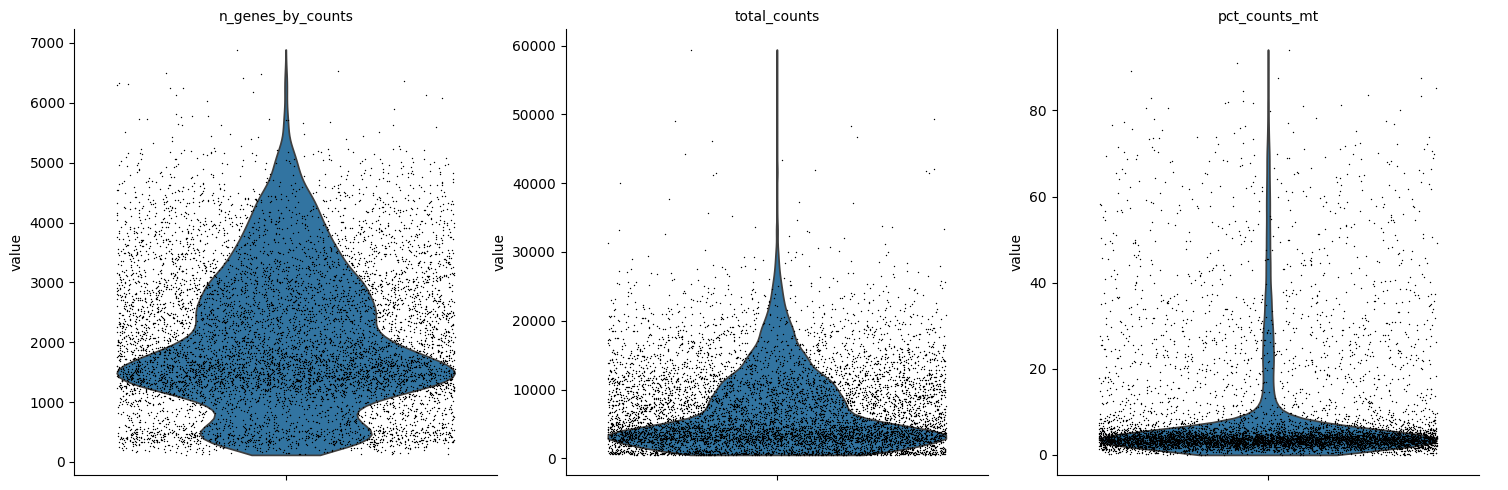

In [10]:
adata.var_names_make_unique()
# sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True) #plotting for wrangling and thresholding

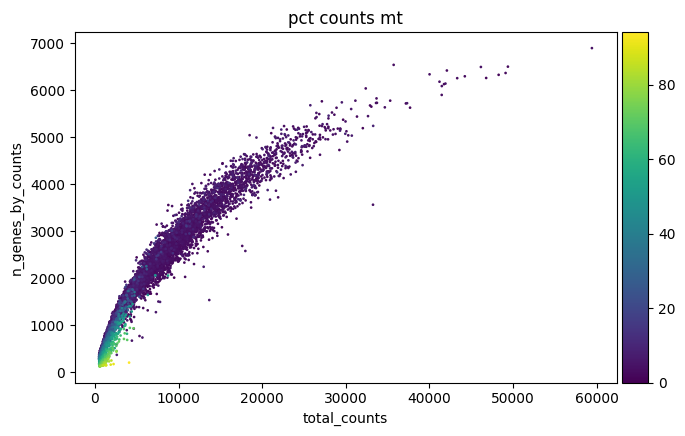

In [11]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color = "pct_counts_mt") # plotting for EDA

In [12]:
adata = adata[adata.obs['pct_counts_mt'] <= 80] #filtering out cells with percent of genes from mitochondrial data > 80% since these cells are most likely non viable

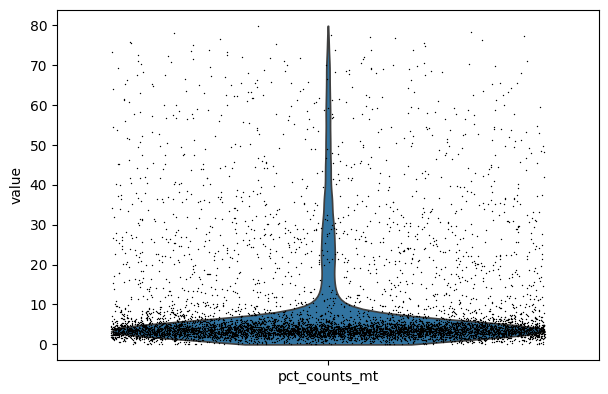

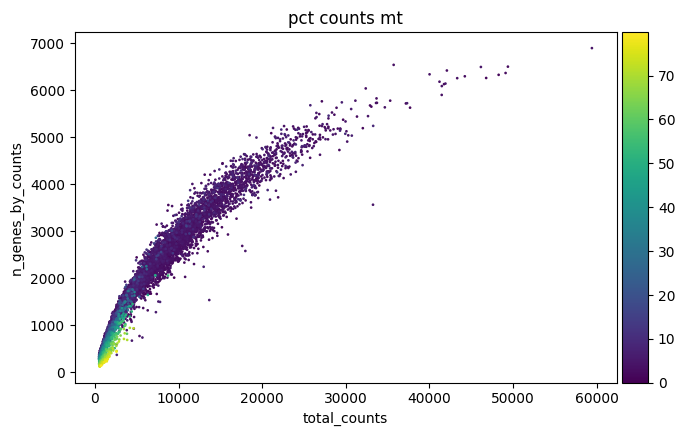

In [13]:
#not necessary
sc.pl.violin(adata, ["pct_counts_mt"], jitter=0.4)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color = "pct_counts_mt")
# plotting for visualization

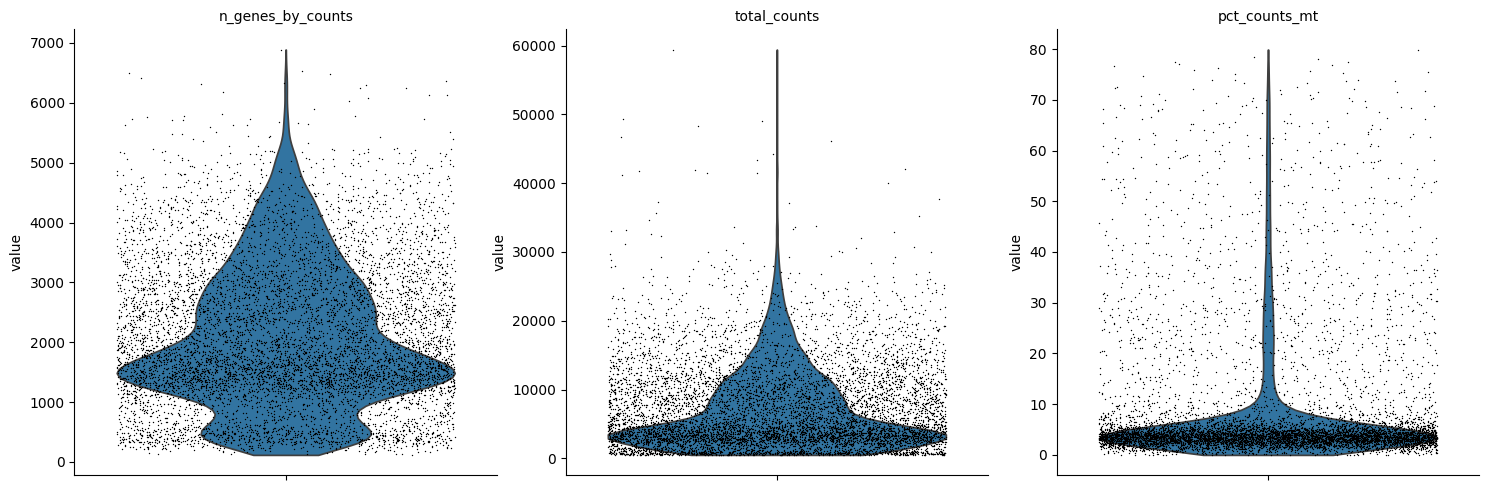

In [14]:
# not necessary
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
# plotting for exploratory analysis

In [15]:
adata.obs #viewing qc metrics, not necessary 

doublet  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACAAATCGTC-1    False                936        1744.0             29.0   
AAACCCACAACTGAAA-1    False               2900       14630.0            430.0   
AAACCCACAATTGAAG-1    False               1673        4267.0            147.0   
AAACCCACATCCTATT-1    False               2815       10950.0            196.0   
AAACCCACATTCGGGC-1    False               1396        2963.0            132.0   
...                     ...                ...           ...              ...   
TTTGTTGCATACTGTG-1    False               1454        2926.0             79.0   
TTTGTTGGTAATGCGG-1    False               5236       33266.0           3006.0   
TTTGTTGGTGGTCAAG-1    False               2269        8088.0            191.0   
TTTGTTGTCAGGCGAA-1    False               1248        2052.0            116.0   
TTTGTTGTCTGAGCAT-1    False               3689       17764.0            782.0   

                    pct_counts_mt  
AAACCCACAAATCGTC-1       1.662844  
AAACCCACAACTGAAA-1       2.939166  
AAACCCACAATTGAAG-1       3.445043  
AAACCCACATCCTATT-1       1.789954  
AAACCCACATTCGGGC-1       4.454944  
...                           ...  
TTTGTTGCATACTGTG-1       2.699932  
TTTGTTGGTAATGCGG-1       9.036253  
TTTGTTGGTGGTCAAG-1       2.361523  
TTTGTTGTCAGGCGAA-1       5.653021  
TTTGTTGTCTGAGCAT-1       4.402162  

[8050 rows x 5 columns]

In [16]:
adata #clean data, filtered out doublets and outliers 

View of AnnData object with n_obs × n_vars = 8050 × 32285
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# 4. Normalization

In [17]:
adata.X.sum(axis = 1) 

matrix([[ 1744.],
        [14630.],
        [ 4267.],
        ...,
        [ 8088.],
        [ 2052.],
        [17764.]], dtype=float32)

In [18]:
sc.pp.normalize_total(adata, target_sum = 1e4) # normalize every cell to 10,000 unique cells (Counts per Million)

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
adata.X.sum(axis = 1) #view after normalization

matrix([[ 9999.982],
        [10000.1  ],
        [10000.086],
        ...,
        [ 9999.903],
        [10000.085],
        [10000.019]], dtype=float32)

In [20]:
sc.pp.log1p(adata) #log transformation

In [21]:
adata.X.sum(axis = 1)

matrix([[2051.301 ],
        [2901.0234],
        [2636.8748],
        ...,
        [2763.2158],
        [2488.7551],
        [3218.9648]], dtype=float32)

In [22]:
adata.raw = adata #saving already preprocessed data into raw slot of AnnData object

# 5. Feature Selection and Dimension Reductionality 

In [23]:
adata.var #viewing genes

mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Xkr4        False                 12     0.001487              99.851283   
Gm1992      False                  0     0.000000             100.000000   
Gm19938     False                 12     0.001611              99.851283   
Gm37381     False                  1     0.000124              99.987607   
Rp1         False                  0     0.000000             100.000000   
...           ...                ...          ...                    ...   
AC124606.1  False                  0     0.000000             100.000000   
AC133095.2  False                  0     0.000000             100.000000   
AC133095.1  False                  0     0.000000             100.000000   
AC234645.1  False                  0     0.000000             100.000000   
AC149090.1  False               2039     0.366092              74.730450   

            total_counts  
Xkr4                12.0  
Gm1992               0.0  
Gm19938             13.0  
Gm37381              1.0  
Rp1                  0.0  
...                  ...  
AC124606.1           0.0  
AC133095.2           0.0  
AC133095.1           0.0  
AC234645.1           0.0  
AC149090.1        2954.0  

[32285 rows x 5 columns]

In [24]:
sc.pp.highly_variable_genes(adata, n_top_genes = 30000) #tenfold dimension reduction + feature selction (selecting for genes that are highly variable) 
# (very permissible to include SCAMP expression)

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


In [25]:
adata = adata[:, adata.var.highly_variable] #make the dataframe contain only highly variable genes

In [26]:
adata

View of AnnData object with n_obs × n_vars = 8050 × 32285
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [27]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:644: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [28]:
sc.pp.scale(adata, max_value = 10)

In [29]:
sc.tl.pca(adata, svd_solver = 'arpack') #Principle Component Analysis for Dimension Reductionality 

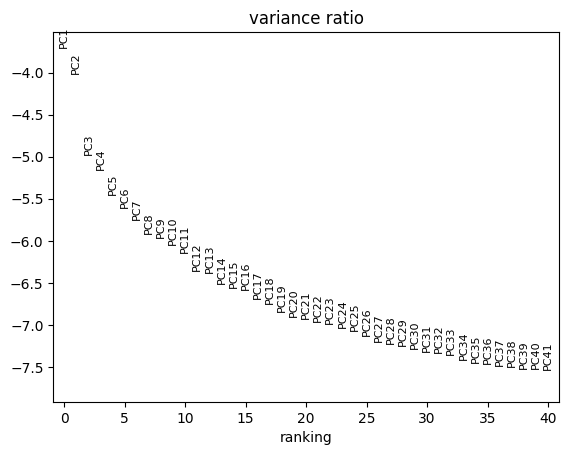

In [30]:
sc.pl.pca_variance_ratio(adata, log = True, n_pcs = 40)

# 6. Clustering 

In [31]:
sc.pp.neighbors(adata, n_pcs = 11) 

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
sc.tl.umap(adata)

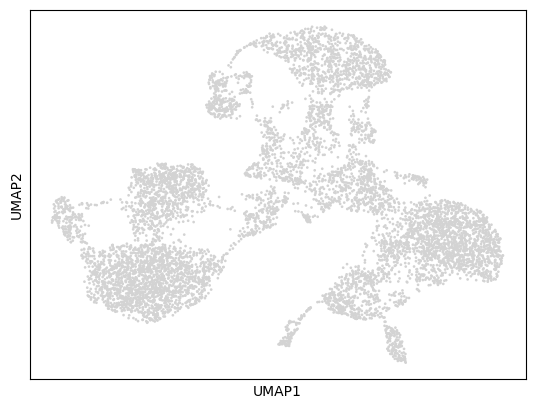

In [33]:
sc.pl.umap(adata)

In [34]:
sc.tl.leiden(adata, resolution = 0.2) #algorithm for clustering

/var/folders/vz/ggcbdp195vb6bwjd2hw6yfsc0000gn/T/ipykernel_7705/3864225830.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.2)


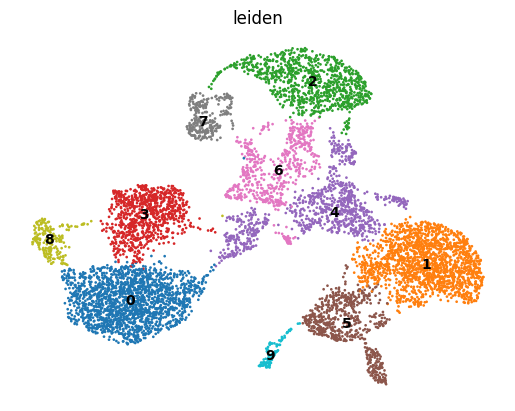

In [35]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = 'on data')

# 7. Finding Marker Genes/Cell Type Labelling 

In [36]:
sc.tl.rank_genes_groups(adata, 'leiden')

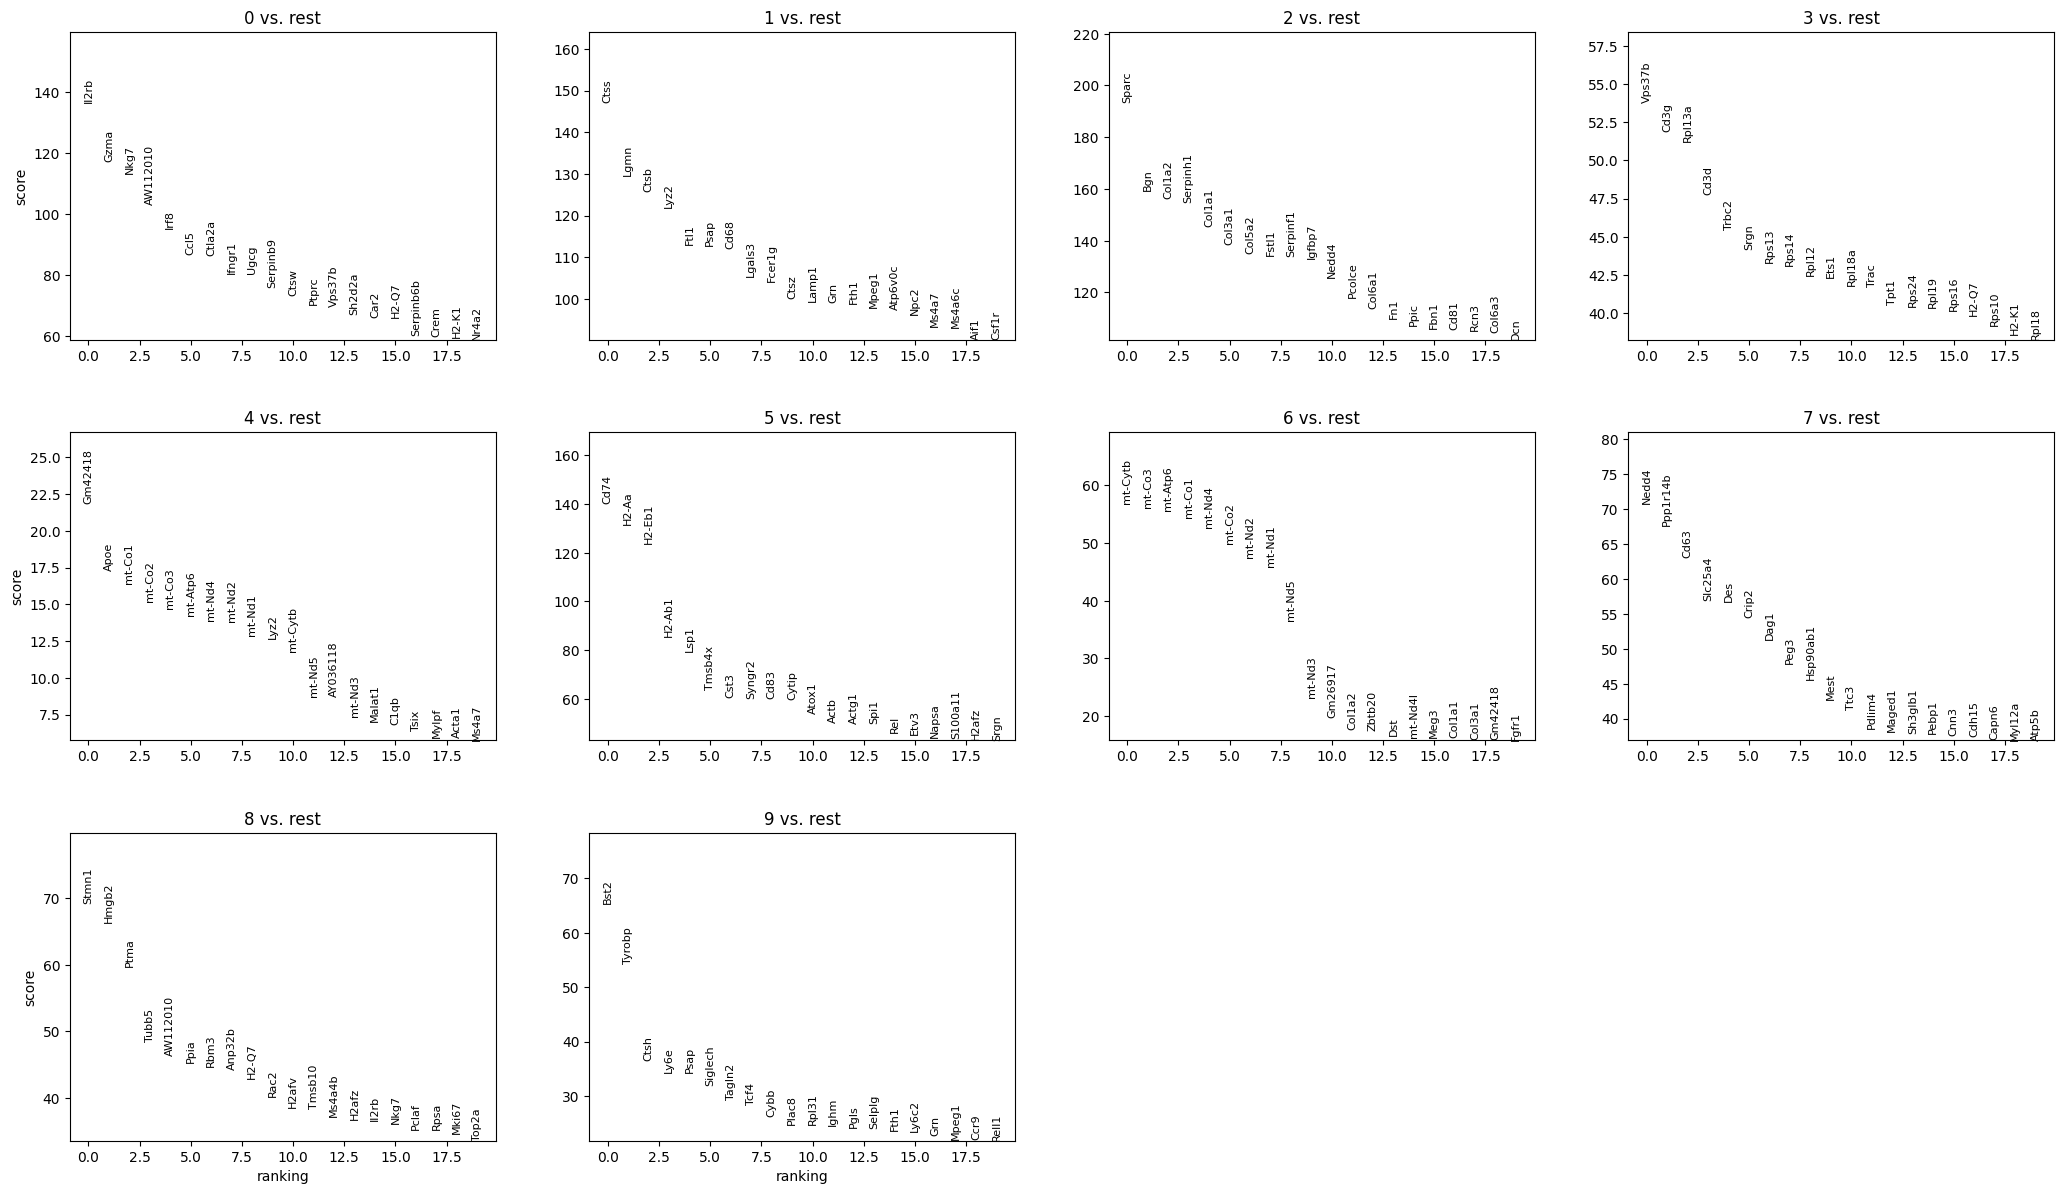

In [37]:
sc.pl.rank_genes_groups(adata, n_genes = 20, sharey = False)

In [38]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
markers

group     names      scores  logfoldchanges     pvals  pvals_adj
0          0     Il2rb  136.388412        4.910453  0.000000   0.000000
1          0      Gzma  117.200035        7.013917  0.000000   0.000000
2          0      Nkg7  113.322601        5.228917  0.000000   0.000000
3          0  AW112010  102.986237        4.564032  0.000000   0.000000
4          0      Irf8   95.382294        4.145898  0.000000   0.000000
...      ...       ...         ...             ...       ...        ...
292651     9    Vps26a    2.509915        0.747240  0.013651   0.049273
292652     9     Hspe1    2.506573        0.543736  0.013764   0.049644
292653     9     Rbm17    2.505938        0.727420  0.013798   0.049749
292654     9     Dapk3    2.505436        1.072016  0.013824   0.049835
292655     9    Chmp2b    2.504023        0.790160  0.013867   0.049984

[30140 rows x 6 columns]

---

### This is gene marker identification. I did this manually (4 times), so this part can be skipped since the clusters have already been identified

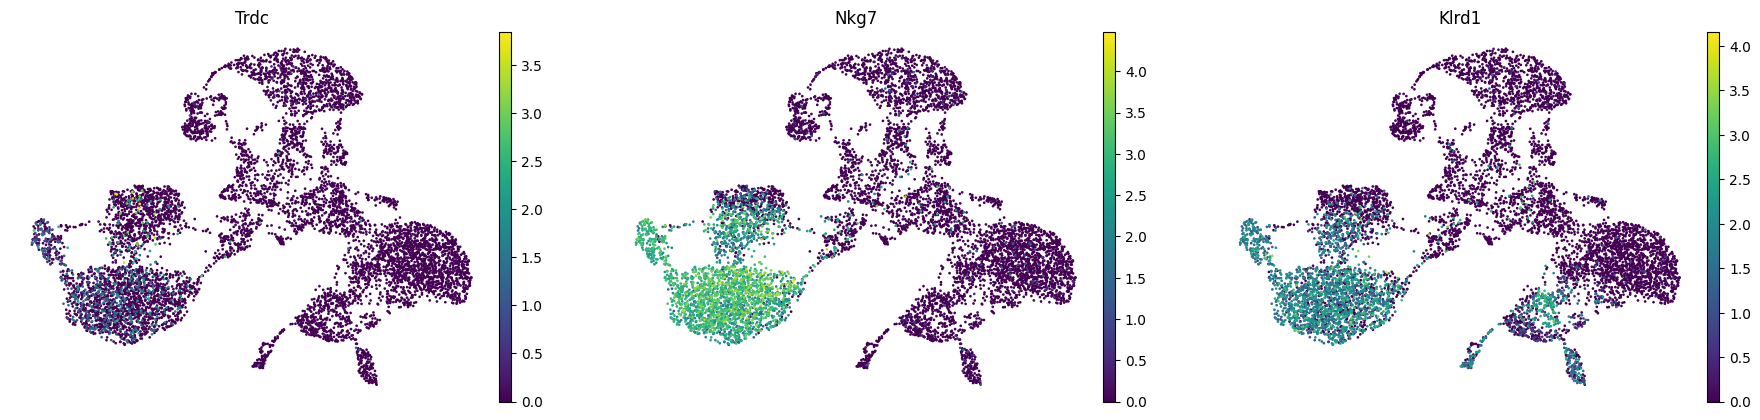

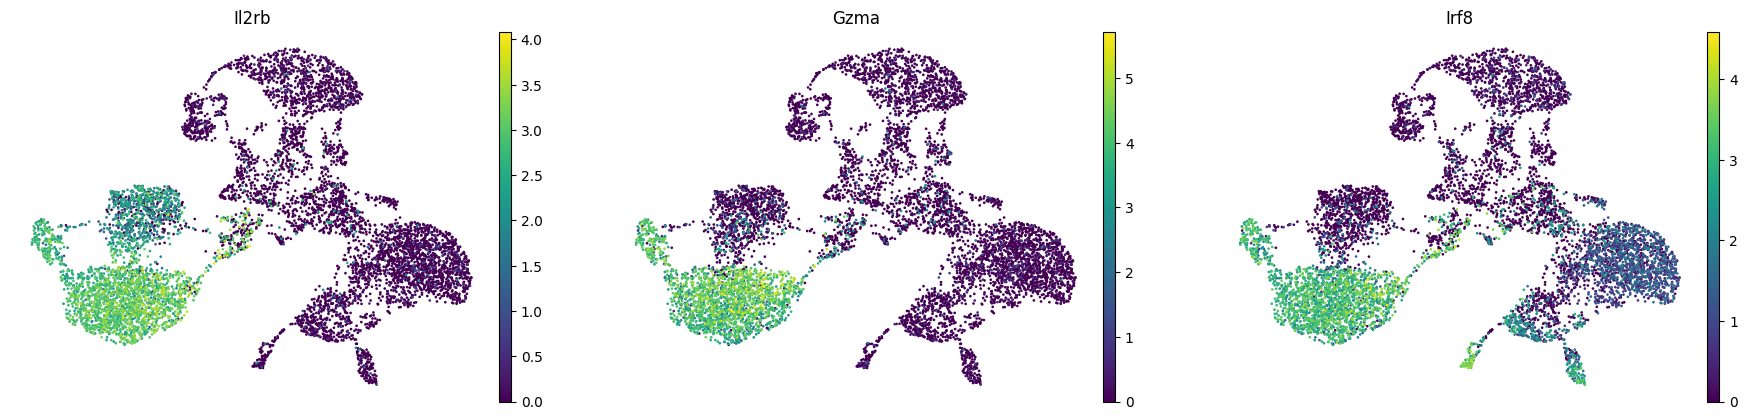

In [39]:
sc.pl.umap(adata, color = ['Trdc', 'Nkg7', 'Klrd1'], frameon = False)
#Markers from rank_genes_groups
sc.pl.umap(adata, color = ['Il2rb', 'Gzma', 'Irf8'], frameon = False) #expect Irf8 to have expression in multiple clusters

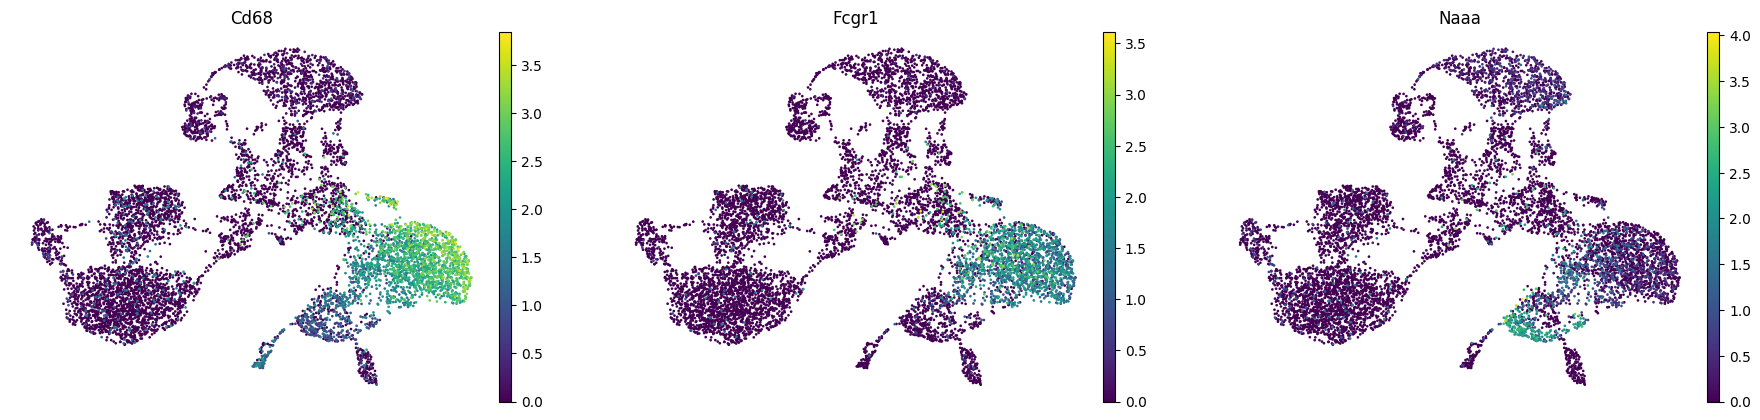

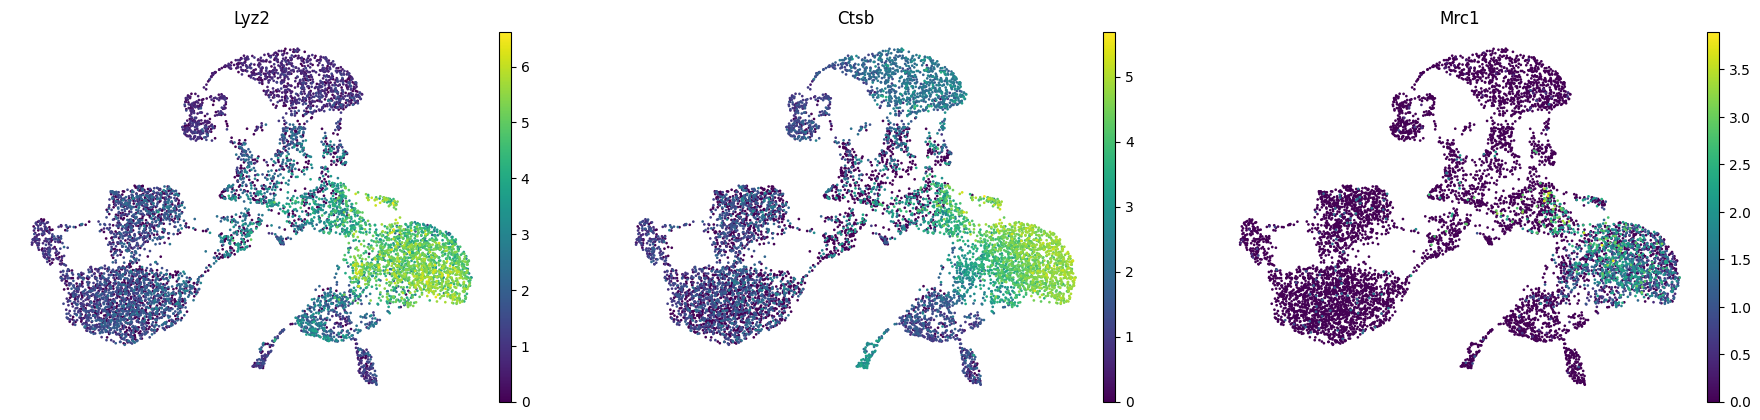

In [40]:
#Identifying cluster 1 - markers from panglao - most likely macrophages
sc.pl.umap(adata, color = ['Cd68', 'Fcgr1', 'Naaa'], frameon = False)
#Markers from rank_genes_groups
sc.pl.umap(adata, color = ['Lyz2', 'Ctsb', 'Mrc1'], frameon = False)


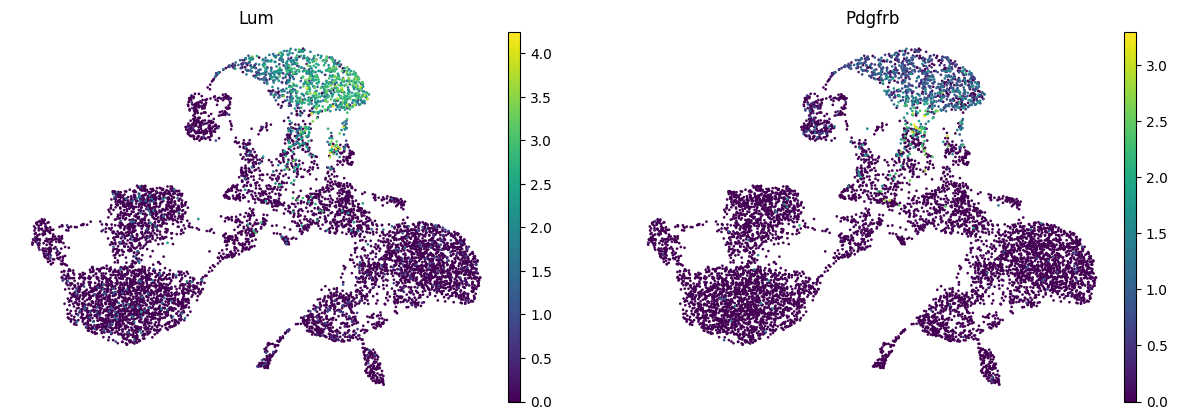

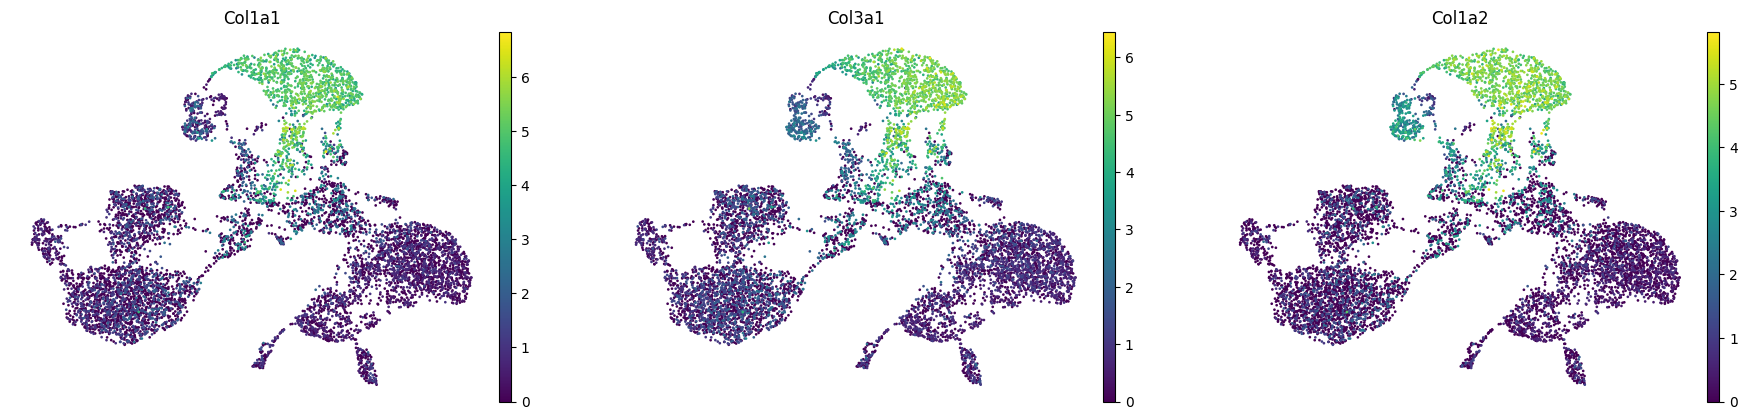

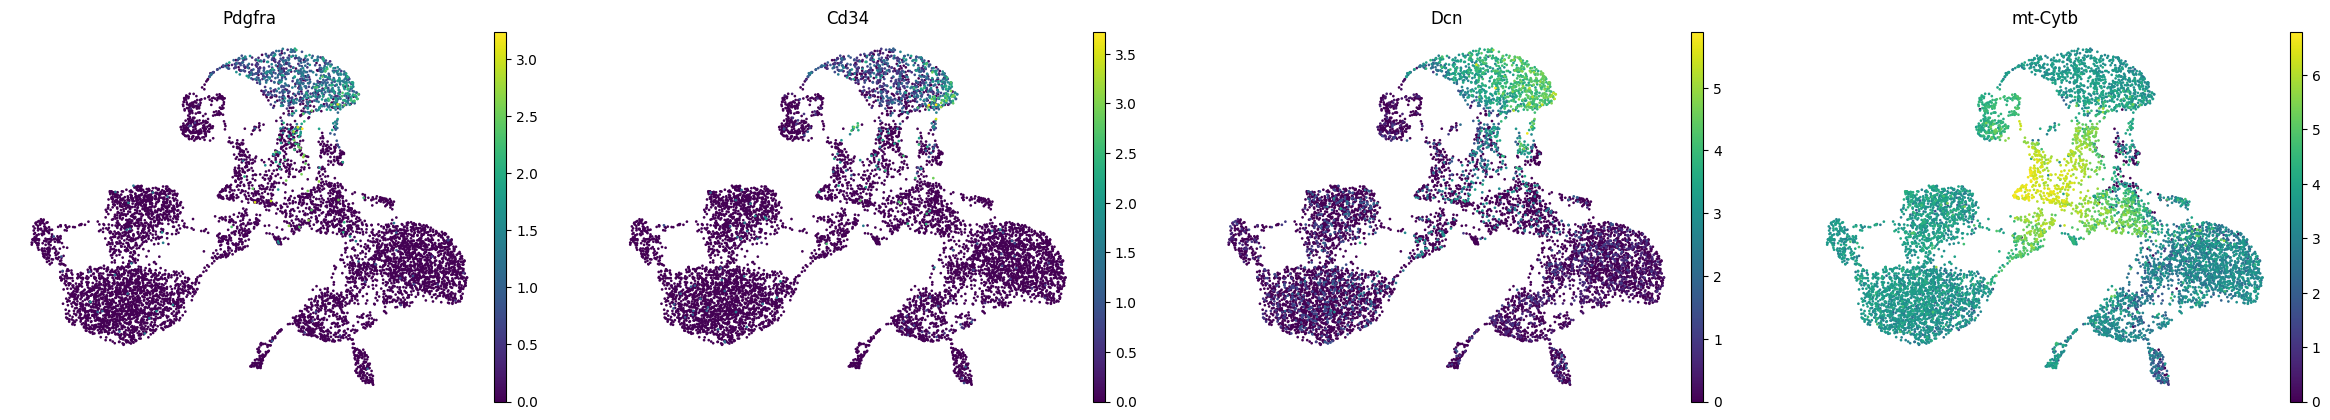

In [41]:
#Identifying cluster 2 & 4 - markers from panglao
sc.pl.umap(adata, color = ['Lum', 'Pdgfrb'], frameon = False)
#Markers from rank_genes_groups
sc.pl.umap(adata, color = ['Col1a1', 'Col3a1', 'Col1a2'], frameon = False)
#Markers from Fitzgerald et al
sc.pl.umap(adata, color = ['Pdgfra', 'Cd34', 'Dcn', 'mt-Cytb'], frameon = False)

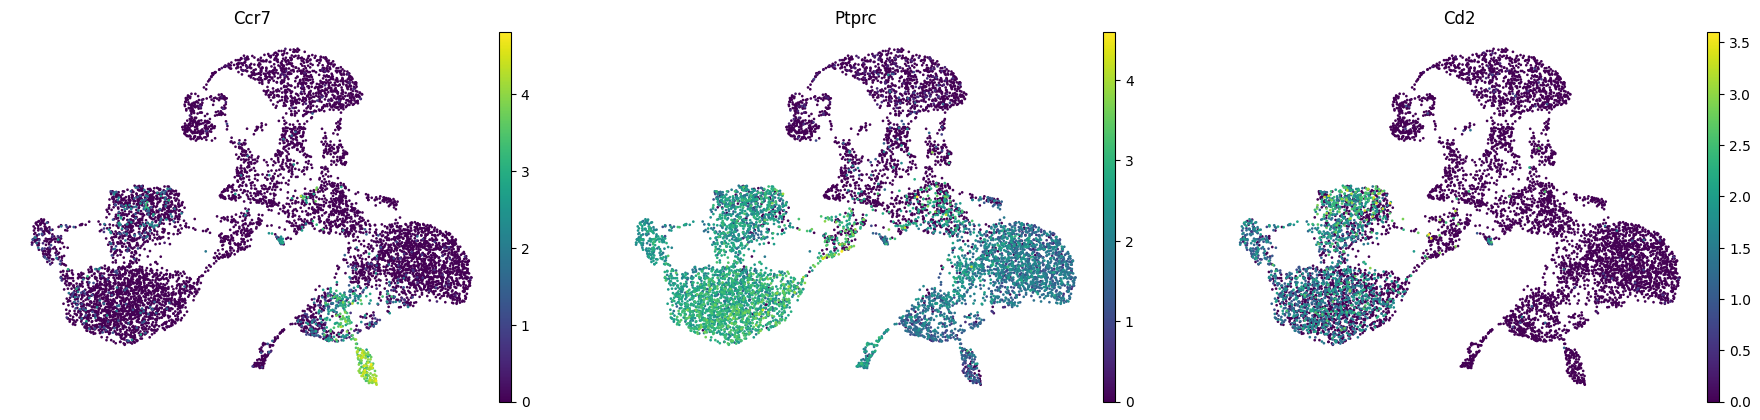

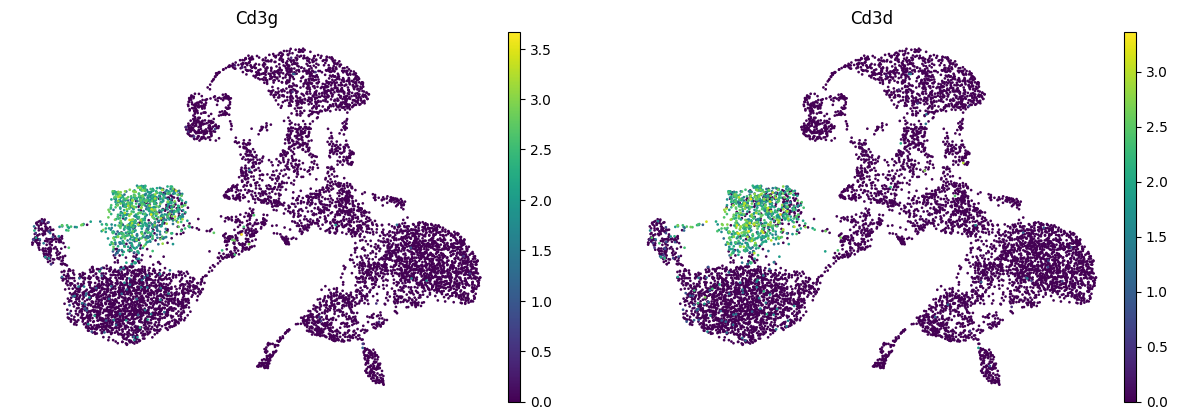

In [42]:
#Identifying cluster 3 - markers from panglao
sc.pl.umap(adata, color = ['Ccr7', 'Ptprc', 'Cd2' ], frameon = False) #Ptprc and Ccr7 not specific enough
#Markers from rank_genes_groups
sc.pl.umap(adata, color = ['Cd3g', 'Cd3d'], frameon = False) #golden marker genes (surpising that unsupervised clustering came out on top here)

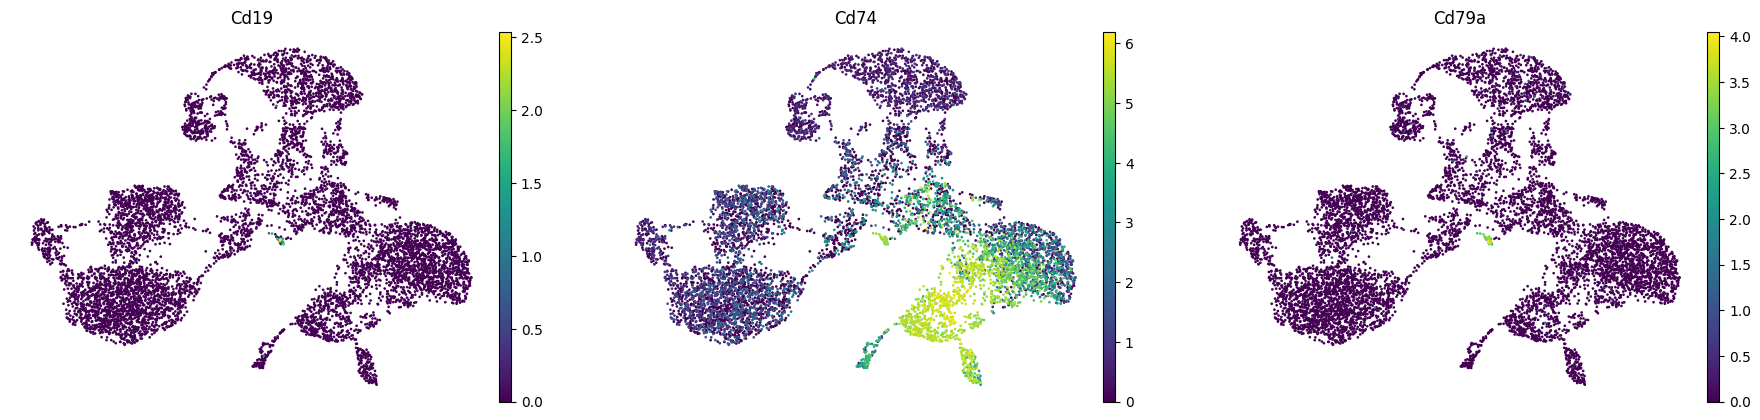

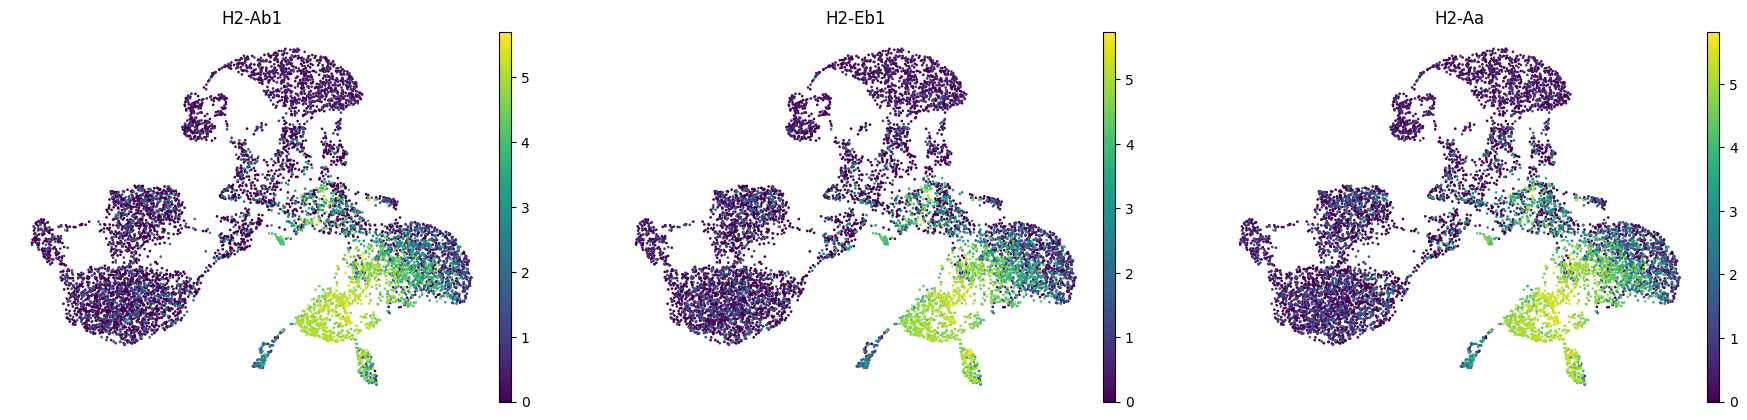

In [43]:
#Identifying cluster 5 - markers from panglao
sc.pl.umap(adata, color = ['Cd19', 'Cd74', 'Cd79a'], frameon = False)
#Markers from rank_genes_groups
sc.pl.umap(adata, color = ['H2-Ab1', 'H2-Eb1', 'H2-Aa'], frameon = False)

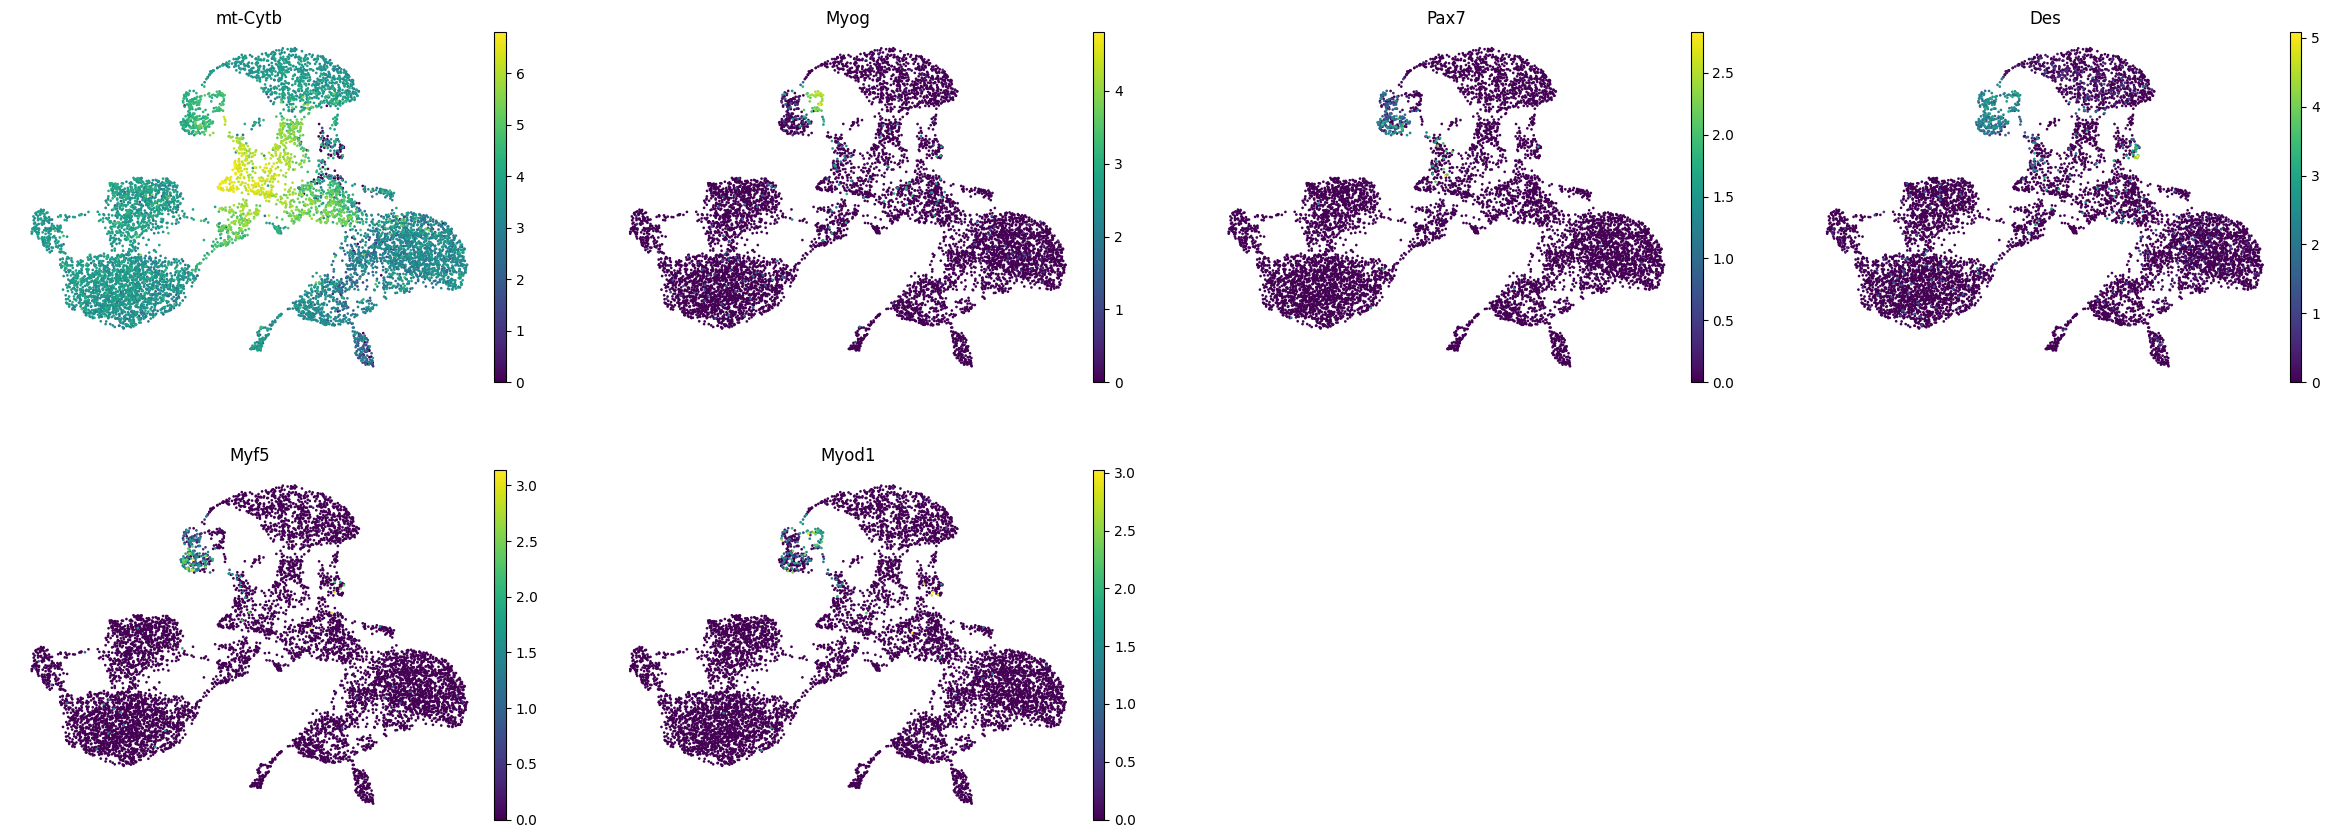

In [44]:
sc.pl.umap(adata, color = ['mt-Cytb', 'Myog', 'Pax7', 'Des', 'Myf5', 'Myod1'], frameon = False)

---

### You can pick up here, where the leiden clusters are identified with their cell types

In [45]:
cell_types = {
    '0' : 'Nk cells',
    '1': 'Macrophages',
    '2' : 'Fibroblasts/FAP',
    '3' : 'T cells',
    '4' : 'Fibroblasts/FAP',
    '5' : 'B cells',
    '6' : 'Fibroblasts/FAP',
    '7' : 'Satellite cells',
    '8' : 'Unknown',
    '9' : 'Macrophages'
}

In [46]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_types)

In [47]:
adata.obs

doublet  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACAAATCGTC-1    False                936        1744.0             29.0   
AAACCCACAACTGAAA-1    False               2900       14630.0            430.0   
AAACCCACAATTGAAG-1    False               1673        4267.0            147.0   
AAACCCACATCCTATT-1    False               2815       10950.0            196.0   
AAACCCACATTCGGGC-1    False               1396        2963.0            132.0   
...                     ...                ...           ...              ...   
TTTGTTGCATACTGTG-1    False               1454        2926.0             79.0   
TTTGTTGGTAATGCGG-1    False               5236       33266.0           3006.0   
TTTGTTGGTGGTCAAG-1    False               2269        8088.0            191.0   
TTTGTTGTCAGGCGAA-1    False               1248        2052.0            116.0   
TTTGTTGTCTGAGCAT-1    False               3689       17764.0            782.0   

                    pct_counts_mt leiden        cell type  
AAACCCACAAATCGTC-1       1.662844      4  Fibroblasts/FAP  
AAACCCACAACTGAAA-1       2.939166      5          B cells  
AAACCCACAATTGAAG-1       3.445043      0         Nk cells  
AAACCCACATCCTATT-1       1.789954      1      Macrophages  
AAACCCACATTCGGGC-1       4.454944      0         Nk cells  
...                           ...    ...              ...  
TTTGTTGCATACTGTG-1       2.699932      0         Nk cells  
TTTGTTGGTAATGCGG-1       9.036253      7  Satellite cells  
TTTGTTGGTGGTCAAG-1       2.361523      1      Macrophages  
TTTGTTGTCAGGCGAA-1       5.653021      0         Nk cells  
TTTGTTGTCTGAGCAT-1       4.402162      1      Macrophages  

[8050 rows x 7 columns]

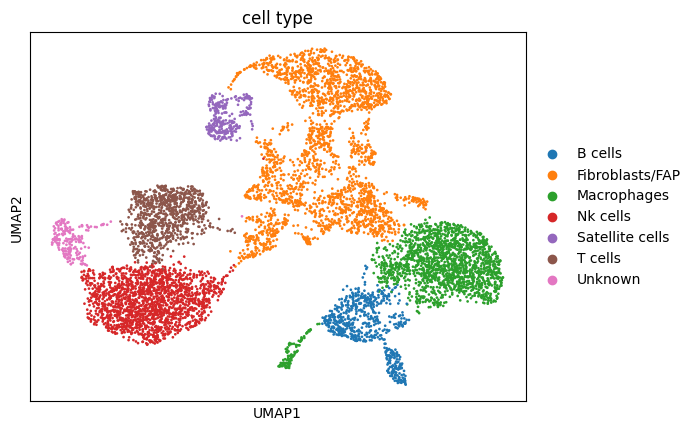

In [48]:
sc.pl.umap(adata, color = ['cell type']) #different cell types in sample

In [49]:
satellite_cells = adata[adata.obs['cell type'] == 'Satellite cells'].copy()

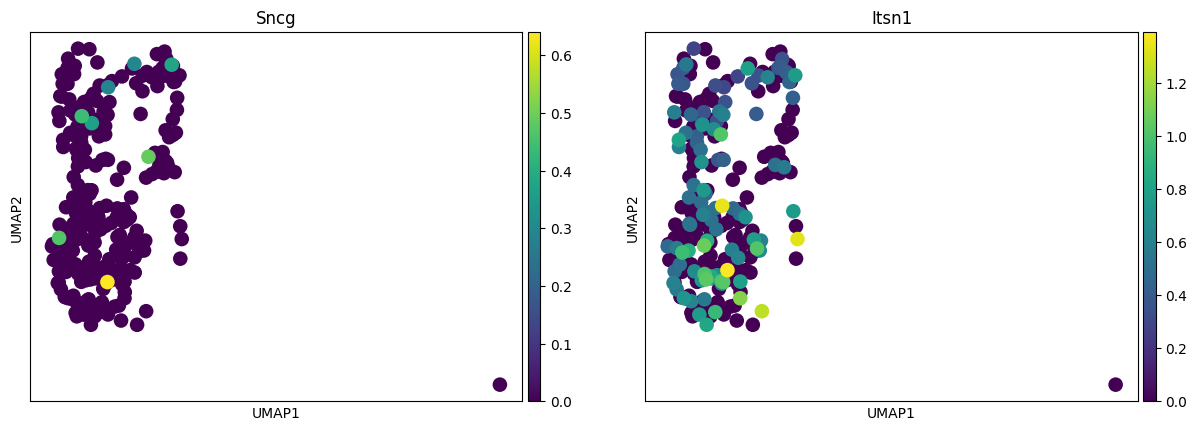

In [50]:
sc.pl.umap(satellite_cells, color = ['Sncg', 'Itsn1']) #gene products interact with SCAMPs

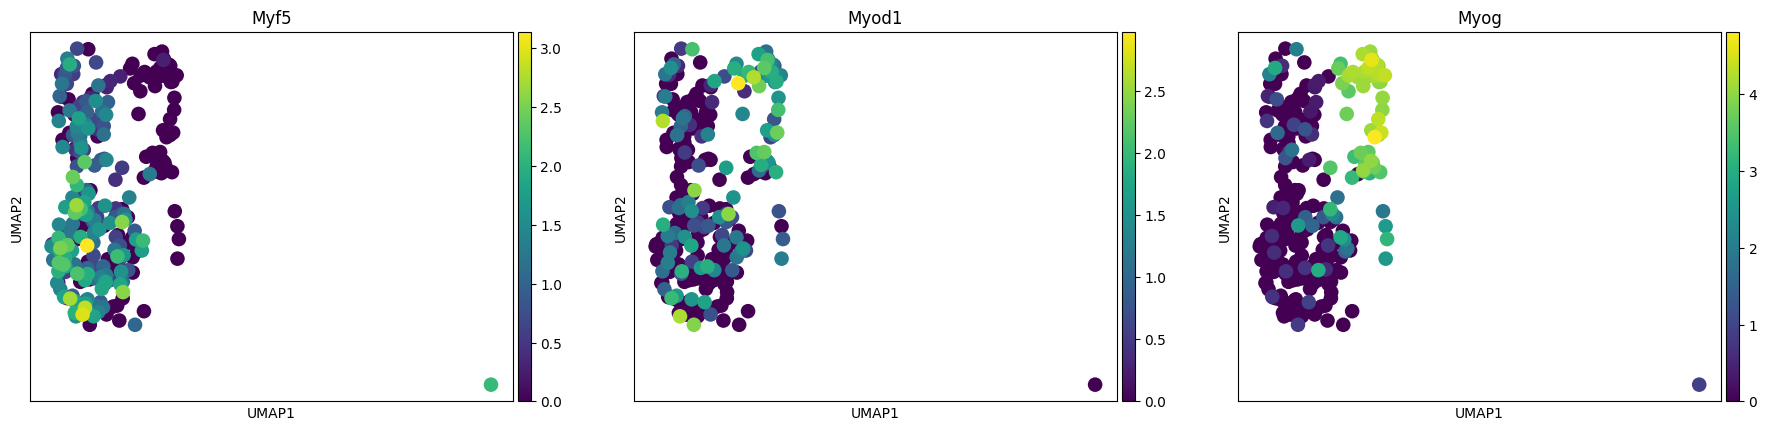

In [51]:
sc.pl.umap(satellite_cells, color = ['Myf5', 'Myod1', 'Myog'])

In [52]:
scamp_genes = ['Scamp1', 'Scamp2', 'Scamp3', 'Scamp4', 'Scamp5']

In [53]:
sat_scamp_expr = satellite_cells[:, scamp_genes]

In [54]:
satellite_cells.var[satellite_cells.var_names.isin(scamp_genes)]

mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Scamp3  False               2080     0.347255              74.222332   
Scamp5  False                349     0.048209              95.674805   
Scamp2  False               2857     0.599827              64.592886   
Scamp4  False                  4     0.000496              99.950428   
Scamp1  False                617     0.090346              92.353451   

        total_counts  highly_variable     means  dispersions  \
Scamp3        2802.0             True  0.374068     0.956435   
Scamp5         389.0             True  0.059442     1.107616   
Scamp2        4840.0             True  0.565270     1.150410   
Scamp4           4.0             True  0.000657     0.534509   
Scamp1         729.0             True  0.096072     1.107035   

        dispersions_norm          mean       std  
Scamp3         -1.099852 -3.883712e-17  0.443622  
Scamp5          0.153347 -9.764446e-18  0.177603  
Scamp2         -0.696602 -1.006234e-16  0.540831  
Scamp4         -0.612844 -4.137477e-20  0.019022  
Scamp1          0.152570  7.502625e-18  0.221073

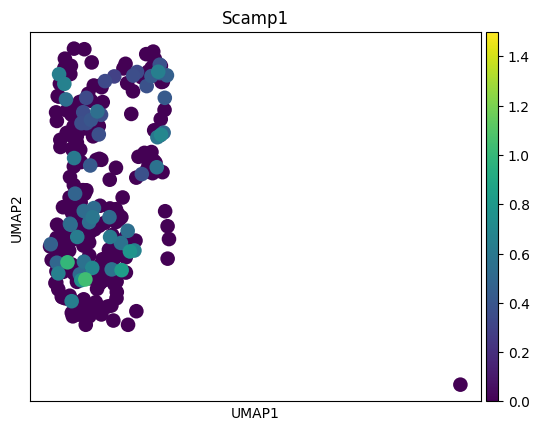

In [67]:
sc.pl.umap(satellite_cells, color = 'Scamp1', vmin = 0.0, vmax = 1.5)

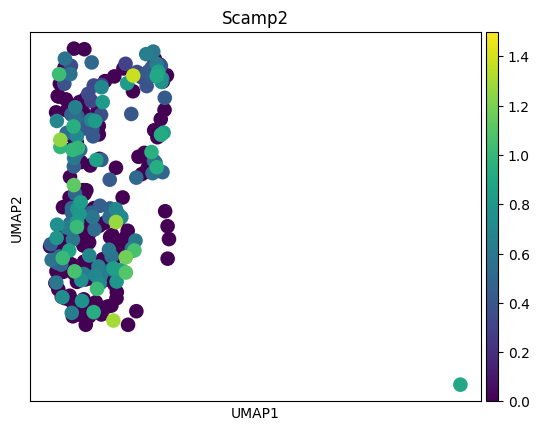

In [68]:
sc.pl.umap(satellite_cells, color = 'Scamp2', vmin = 0.0, vmax = 1.5)

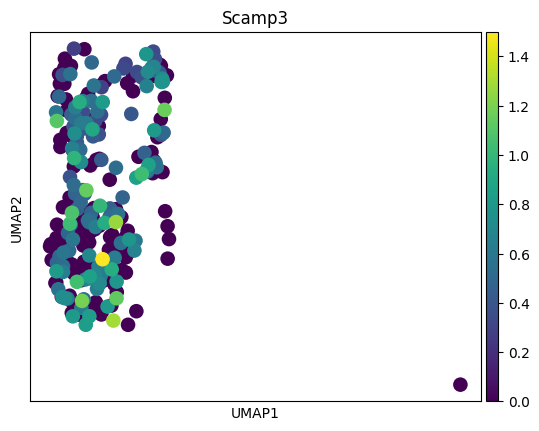

In [69]:
sc.pl.umap(satellite_cells, color = 'Scamp3', vmin = 0.0, vmax = 1.5)

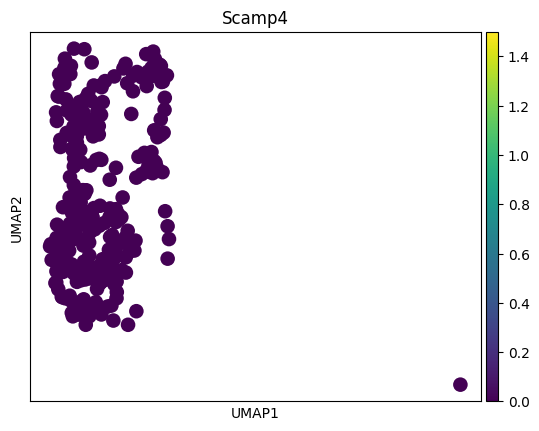

In [70]:
sc.pl.umap(satellite_cells, color = 'Scamp4', vmin = 0.0, vmax = 1.5)

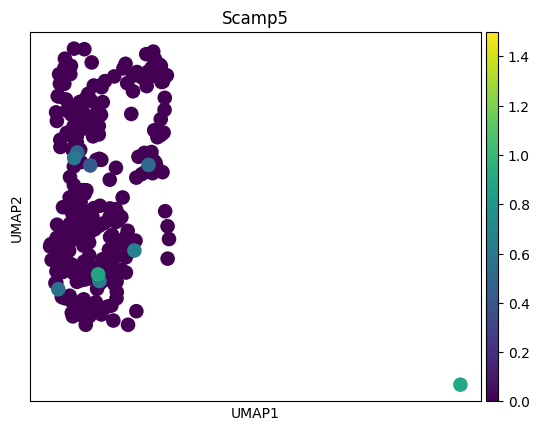

In [71]:
sc.pl.umap(satellite_cells, color = 'Scamp5', vmin = 0.0, vmax = 1.5)

(0.0, 1.7)

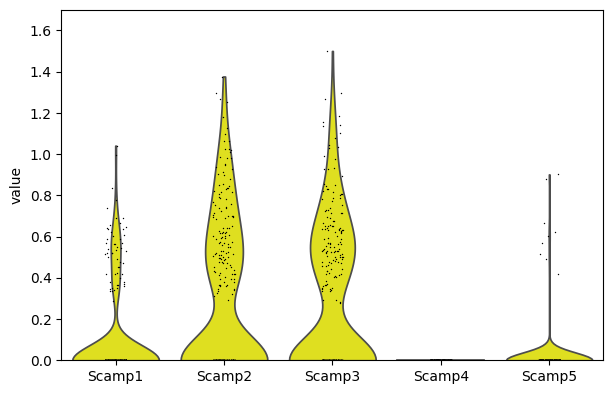

In [56]:
violinax1 = sc.pl.violin(satellite_cells, scamp_genes, color = 'yellow', show = False)
plt.ylim(0.0, 1.7)
#figure 1 a

In [57]:
#get a list of observation names from satellite cells adata object
satellite_obs = list(satellite_cells.obs_names)

#reread in the original adata object 
reread_adata = sc.read_h5ad('/Users/danielpintard/Documents/Code/Bioinformatics/scRNAseq-SCAMPs/data/doublet_filtered/young_filtered_adata.h5ad')

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [58]:
#create a new column in observations of reread adata indicating which cell are sattelite cells 
#probably something along the lines of:
# if obs in satellite cell names, then assign true in reread adata object

satellite_cell_values = np.where(reread_adata.obs_names.isin(satellite_obs), True, False)
reread_adata.obs['satellite_cell'] = satellite_cell_values

In [59]:
#this way I will have the raw, non normalized, non processed counts of genes in the satellite cell population
raw_satcell_adata = reread_adata[reread_adata.obs['satellite_cell'] == True]
#then what I will do is get rid of all of the variables other than scamp genes 
#quantify their counts and then use that to get relative gene expression compared to all the other cells

In [60]:
raw_satcell_scamp = raw_satcell_adata[:, raw_satcell_adata.var_names.isin(scamp_genes)] 

In [61]:
raw_satcell_scamp.X.sum(axis = 0)

matrix([[189.,   9., 195.,   0.,  62.]], dtype=float32)

In [62]:
reread_adata = reread_adata[reread_adata.obs['satellite_cell'] == True]

In [63]:
sc.pp.calculate_qc_metrics(reread_adata, inplace = True)

/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/scRNAseq1/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [64]:
tot_counts = reread_adata.obs.total_counts

In [65]:
tot_counts.sum(axis = 0)

4125764.0

In [ ]:
#raw_satcell_scamp.write('yng_satcell_scamp.h5ad')
# already saved to data/satellite_cell_adata directory